In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = "/content/drive/MyDrive/Data Science Internship/Face_Mask_Dataset"
CATEGORIES = ["Face_Mask", "No_Mask"]

In [5]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

KeyboardInterrupt: ignored

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


[INFO] training head...
Epoch 1/20
48/48 [==============================] - 69s 1s/step - loss: 0.3680 - accuracy: 0.8815 - val_loss: 0.1171 - val_accuracy: 0.9974
Epoch 2/20
48/48 [==============================] - 66s 1s/step - loss: 0.1053 - accuracy: 0.9876 - val_loss: 0.0430 - val_accuracy: 1.0000
Epoch 3/20
48/48 [==============================] - 66s 1s/step - loss: 0.0635 - accuracy: 0.9902 - val_loss: 0.0228 - val_accuracy: 1.0000
Epoch 4/20
48/48 [==============================] - 65s 1s/step - loss: 0.0391 - accuracy: 0.9961 - val_loss: 0.0143 - val_accuracy: 1.0000
Epoch 5/20
48/48 [==============================] - 65s 1s/step - loss: 0.0268 - accuracy: 0.9974 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 6/20
48/48 [==============================] - 65s 1s/step - loss: 0.0236 - accuracy: 0.9948 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 7/20
48/48 [==============================] - 65s 1s/step - loss: 0.0205 - accuracy: 0.9974 - val_loss: 0.0059 - val_accuracy: 1.0

In [ ]:
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
#print("[INFO] saving mask detector model...")
#model.save("mask_detector.model", save_format="h5")
!mkdir -p saved_model
model.save('saved_model/my_model') 

              precision    recall  f1-score   support

   Face_Mask       1.00      1.00      1.00       190
     No_Mask       1.00      1.00      1.00       200

    accuracy                           1.00       390
   macro avg       1.00      1.00      1.00       390
weighted avg       1.00      1.00      1.00       390

[INFO] saving mask detector model...


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


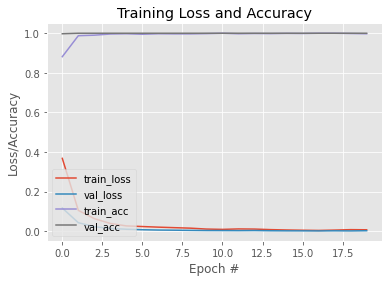

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [6]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os

def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

In [8]:
prototxtPath = "/content/drive/MyDrive/Data Science Internship/Face Mask Detection/Face_detection_model/deploy.prototxt"
weightsPath = "/content/drive/MyDrive/Data Science Internship/Face Mask Detection/Face_detection_model/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
#maskNet = load_model("mask_detector.model")

In [20]:
model.save('/content/drive/MyDrive/Data Science Internship/Face Mask Detection/mask_detection_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
def define_training_data(data, classes, directory, size):
  for cat in classes:
    path = os.path.join(directory, cat)
    class_code = classes.index(cat)

    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path,img))
        new_arr = cv2.resize(img_arr,(size,size))
        data.append([new_arr,class_code])
      except Exception as e:
        print(e)
        break

In [ ]:
import os

directory = '/content/drive/MyDrive/Data Science Internship/Face_Mask_Dataset'
classes = ['Face_Mask','No_Mask']
data = []
size = 224 # image net uses 224 -> considered as standard size

define_training_data(data, classes, directory, size)

In [ ]:
print(len(data))


1950


In [ ]:
import random 

random.shuffle(data)


X = [] # features
y = [] # labels

for feature, label in data:
  X.append(feature)
  y.append(label)

In [ ]:
X = np.array(X).reshape(-1, size, size, 3)
y = np.array(y).reshape(-1,1)

print('X Shape: ',X.shape)
print('\ny Shape: ',y.shape)

X Shape:  (1950, 224, 224, 3)

y Shape:  (1950, 1)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = tf.keras.applications.MobileNetV2(weights='imagenet',
                                          input_tensor = tf.keras.layers.Input(shape=(224,224,3))) # using pre trained model
model.summary()

14548992/14536120 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________

Tuning weights

In [ ]:
initial_input = model.layers[0].input
initial_output = model.layers[-4].output

In [ ]:
flat_layer = layers.Flatten()(initial_output)
final_output = layers.Dense(1)(flat_layer) 
final_output = layers.Activation('sigmoid')(final_output)

In [ ]:
model_1 = keras.Model(inputs = initial_input , outputs = final_output)

In [ ]:
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras.optimizers import Adam
INIT_LR = 1e-4
epochs = 5
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / epochs)

model_1.compile(loss = 'binary_crossentropy',
                optimizer = opt,
                metrics = ['accuracy'])

In [ ]:
H = model_1.fit(X, y,
            epochs = epochs,
            validation_split = .2)

Epoch 1/5
49/49 [==============================] - 316s 6s/step - loss: 0.6713 - accuracy: 0.9397 - val_loss: 1.9373 - val_accuracy: 0.7667
Epoch 2/5
49/49 [==============================] - 307s 6s/step - loss: 1.6731e-09 - accuracy: 1.0000 - val_loss: 2.3990 - val_accuracy: 0.7615
Epoch 3/5
49/49 [==============================] - 305s 6s/step - loss: 1.9624e-08 - accuracy: 1.0000 - val_loss: 0.9117 - val_accuracy: 0.8795
Epoch 4/5
49/49 [==============================] - 303s 6s/step - loss: 1.2509e-12 - accuracy: 1.0000 - val_loss: 0.2827 - val_accuracy: 0.9692
Epoch 5/5
49/49 [==============================] - 305s 6s/step - loss: 1.0641e-11 - accuracy: 1.0000 - val_loss: 0.0592 - val_accuracy: 0.9923


In [ ]:
model_1.save('FaceMaskModel.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


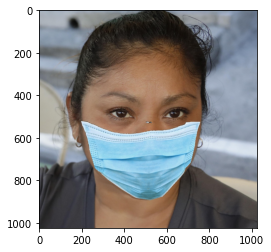

In [ ]:
img_1 = cv2.imread('/content/drive/MyDrive/Data Science Internship/Face_Mask_Dataset/Face_Mask/00002_Mask.jpg')
plt.imshow(cv2.cvtColor(img_1,cv2.COLOR_BGR2RGB))

In [ ]:
test_img_1 = np.expand_dims(cv2.resize(img_1, (224,224)), axis = 0) / 255.0

In [ ]:
y_pred = model_1.predict(test_img_1)
y_pred

array([[0.99999917]], dtype=float32)

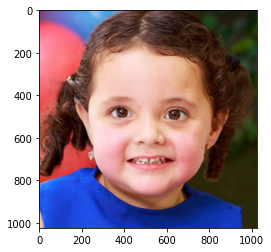

In [ ]:
img_2 = cv2.imread('/content/drive/MyDrive/Data Science Internship/Face Mask Detection/test_1.png')
plt.imshow(cv2.cvtColor(img_2,cv2.COLOR_BGR2RGB))

In [ ]:
test_img_2 = np.expand_dims(cv2.resize(img_2, (224,224)), axis = 0) / 255.0


In [ ]:
y_pred = model_1.predict(test_img_2)
y_pred

array([[0.9999987]], dtype=float32)